In [1]:
import pandas as pd
import numpy as np
import subprocess, re, time, string, random

In [282]:
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.neighbors import KNeighborsClassifier  as KNC
from sklearn.metrics import roc_curve,accuracy_score,roc_auc_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def generate_data(n_samples=10000, n_features = 20,weights = [0.3,1]):
    return make_classification(n_samples=n_samples, n_features=n_features, n_classes=2, weights=weights)

In [60]:
def getROC_Curve(pred,real):
    fpr, tpr, thresholds = (roc_curve(pred,real))
    return fpr[1],tpr[1]

def get_positive_rate(X, y, k_fold = 5, clf = KNC(n_neighbors=7)):
    fpr,tpr = 0,0
    if type(y) != np.ndarray:
        y = np.asarray(y)
    kf = KFold(len(y), k_fold, shuffle=True, random_state=1)
    for train, test in kf:
        X_train, X_test, y_train, y_test = X[train,:], X[test,:], y[train], y[test]
        clf.fit(X_train, y_train)
        n_fpr,n_tpr = getROC_Curve(clf.predict(X_test),y_test)
        fpr += n_fpr
        tpr += n_tpr
    return fpr/k_fold,tpr/k_fold

def get_exp_positive_rate(X, y, k_fold = 5, clf = KNC(n_neighbors=7)):    
    et,ef = [],[]
    if type(y) != np.ndarray:
        y = np.asarray(y)
    kf = KFold(len(y), k_fold, shuffle=True, random_state=1)
    for train, test in kf:
        efpr,etpr = 0,0
        X_train, X_test, y_train, y_test = X[train,:], X[test,:], y[train], y[test]
        clf.fit(X_train, y_train)
        proba = clf.predict_proba(X_test)
        
        count_fpr = 0
        for i,item in enumerate(y_test):
            if item==0:
                efpr += proba[i][0]
                count_fpr += 1
            elif item==1:
                etpr +=proba[i][1]
                
        efpr = efpr/count_fpr
        etpr = etpr/(len(y_test)-count_fpr)
        
        et.append(etpr),ef.append(efpr)
    return np.average(ef),np.average(et)

In [61]:
def kld(p, q):
        p = np.asarray(p, dtype=np.float)
        q = np.asarray(q, dtype=np.float)
        return np.sum(np.where(p != 0,p * np.log(p / q), 0))

In [93]:
def ae(p, q):
        #
        p = np.asarray(p, dtype=np.float)
        q = np.asarray(q, dtype=np.float)
        return np.average(np.abs(q-p))

# SVM$_{perf}(KLD)$

### For 2 point

In [269]:
def obtainSVMperfTwoPoint(sentiment,tweets,name = 'noname'):
    path = 'SVMperf/'
    file = open(path+str(name)+'.txt','w')
    for i in range(len(sentiment)):        
        if sentiment[i] == 1:
            file.write('1 ')
            for j,tw in enumerate(tweets[i]):
                if tw != 0:
                    file.write(str(j+1)+':'+str(tw)+' ')
            file.write('\n')
        elif sentiment[i] == 0:
            file.write('-1 ')
            for j,tw in enumerate(tweets[i]):
                if tw != 0:
                    file.write(str(j+1)+':'+str(tw)+' ')
            file.write('\n')
        else:
            file.write('0 ')
            for j,tw in enumerate(tweets[i]):
                if tw != 0:
                    file.write(str(j+1)+':'+str(tw)+' ')
            file.write('\n')
    file.close()

In [314]:
def SVMperfForTwoPoint(train=None,test=None,model=None,predictions=None, option = 10):
    train = "SVMperf/train.txt"
    test = "SVMperf/test.txt"
    model = "SVMperf/model.txt"
    predictions = "SVMperf/predictions.txt"
#     subprocess.Popen(["svm-perf-original/svm_perf_learn","-c",str(option),train,model], stdout=subprocess.PIPE)
    !svm-perf-original/svm_perf_learn -c $option $train $model
    predict = subprocess.Popen(["svm-perf-original/svm_perf_classify",test,model,predictions], stdout=subprocess.PIPE)
    return predict.communicate()[0]

### For 5 point

In [554]:
def obtainSVMperfFivePoint(sentiment,tweets,name = 'noname'):
    path = 'SVMperf/five-point/'
    for m in range(-2,3,1):
        file = open(path+str(name)+'('+str(m)+')'+'.txt','w')
        for i in range(len(sentiment)):
            if str(sentiment[i]) == str(m):
                file.write('1 ')
                for j,tw in enumerate(tweets[i]):
                    if tw != 0.0:
                        file.write(str(j+1)+':'+str(tw)+' ')
                file.write('\n')
            elif str(sentiment[i]) == 'UNKNOWN':
                file.write('0 ')
                for j,tw in enumerate(tweets[i]):
                    if tw != 0.0:
                        file.write(str(j+1)+':'+str(tw)+' ')
                file.write('\n')
            else:
                file.write('-1 ')
                for j,tw in enumerate(tweets[i]):
                    if tw != 0.0:
                        file.write(str(j+1)+':'+str(tw)+' ')
                file.write('\n')
        file.close()

In [646]:
def SVMperfForFivePoint(train=None,test=None,model=None,predictions=None, option = 10):
    for i in range(-2,3,1):
        train = "SVMperf/five-point/train("+str(i)+").txt"
        test = "SVMperf/five-point/test("+str(i)+").txt"
        model =  "SVMperf/five-point/model("+str(i)+").txt"
        subprocess.call(["svm-perf-original/svm_perf_learn","-c",str(option),train,model], stdout=subprocess.PIPE)              
        predictions = "SVMperf/five-point/predictions("+str(i)+").txt"
        predict = subprocess.Popen(["svm-perf-original/svm_perf_classify",test,model,predictions], stdout=subprocess.PIPE) 

In [558]:
obtainSVMperfFivePoint(y_train.tolist(),X_train.toarray(), "train")
obtainSVMperfFivePoint(y_test.tolist(),X_test.toarray(), "test")

In [693]:
def get_predictions_5(i = 0):
    predictions = []
    f = open('SVMperf/five-point/predictions('+str(i)+').txt','r')
    for line in f:
        if float(line)>=0  :
            predictions.append(1)
        elif float(line)<0:
            predictions.append(0)
#     |predictions = CC(predictions)
    return predictions

In [738]:
SVMperfForFivePoint(option =1050)
# a = []
# for i in range(-2,3,1):
#     b = len(get_predictions_5(i)) - pd.Series(get_predictions_5(i)).value_counts()[0]
#     a.append(i for )
# #     a.append(pd.Series(get_predictions_5(i)).value_counts()[1])
# #     a.append(CC(get_predictions_5(i))[1])
# # a = normalize(np.array(a).reshape((1, -1)), norm='l1',axis=1)[0]
# a = [i*len(get_predictions_5(i)) - pd.Series(get_predictions_5(i)).value_counts()[0] for i in range(-2,3,1)]
# print(a)
# print(kld(CC(y_test),CC(a)))

In [740]:
a = [[i]*(len(get_predictions_5(i)) - pd.Series(get_predictions_5(i)).value_counts()[0]) for i in range(-2,3,1)]
b = []
for ar in a:
    if len(ar)<2:
        b.append(ar[0])
    else:
        for i in ar:
            b.append(i)
print(kld(CC(y_test),CC(b))) 

0.0466937213022


In [702]:
print(a)
print(CC(y_test))

[ 0.29711699  0.29711699  0.29711699  0.10660283  0.00204618]
 0    4303
 1    3239
-1    1123
 2     208
-2      74
dtype: int64
[0.48094333296076897, 0.36202078909131552, 0.12551693305018441, 0.023248016094780374, 0.0082709288029507097]


In [700]:
# for i in range(-2,3,1):
#     print((get_predictions_5(i))[1])

# Predictions

In [315]:
def get_predictions(path = ''):
    predictions = []
    f = open('SVMperf/predictions'+path+'.txt','r')
    for line in f:
        if float(line)>=0  :
            predictions.append(1)
        elif float(line)<0:
            predictions.append(0)
#     predictions = CC(predictions)
    return predictions

In [752]:
def CC(sequence):
    sequence = pd.Series(sequence)
    if (len(sequence.value_counts()))>1:
        return [value/sequence.count() for value in sequence.value_counts()]
    else:
        if sum(sequence.get_values()) > 0:
            return [0.99, 0.01]
        else:
            return [0.01, 0.99]
        
def PCC(probabilities):
#     pcc = list(np.average(probabilities.T,axis=1))
    pcc = (np.average(probabilities.T,axis=1)).tolist()
    pcc.reverse()
    return pcc

def ACC(sequence,fpr,tpr):
    sequence = pd.Series(sequence)
    acc = [(value/sequence.count() - fpr)/(tpr - fpr) for value in sequence.value_counts()]
    
    for i,share in enumerate(acc):
        if share >= 1.:
            acc[i] = 0.99
        elif share <= 0.:
            acc[i] = 0.01
    
    acc = normalize(np.array(acc).reshape((1, -1)), norm='l1',axis=1)[0]
    
    if len(acc)>1:
        return acc
    else:
        if sum(sequence.get_values()) > 0:
            return [0.99, 0.01]
        else:
            return [0.01, 0.99]

def PACC(sequence,probabilities,e_fpr,e_tpr):
    probabilities = pd.DataFrame(probabilities)
    pcc  = PCC(probabilities)
    pacc = [min(1.0,(pcc[i] - e_fpr))/max(0.0001,(e_tpr - e_fpr)) for i,column_name in enumerate(probabilities.columns)]    
    
    for i,item in enumerate(pacc):
        if item<0:
            pacc[i] = pcc[i]
   
    pacc = normalize(np.array(pacc).reshape((1, -1)), norm='l1',axis=1)[0]
   
    return pacc

def EM(y_train, pred_prob, stop_delta=0.0001):        
        cc = CC(y_train)        
        pr_s = cc
        
        prob_t = pred_prob.T        
        prob_t_s = prob_t
        
        delta = 1
        delta_s = 1
        count = 0
        
        while delta>stop_delta and delta<=delta_s and count<500:
            # E-step
            for clss in range(len(cc)):
                prob_t_s[clss] = prob_t[clss]*(pr_s[clss]/cc[clss]) 
            prob_t_s = normalize(prob_t_s, norm='l1',axis=0) 
            # M-step            
            pr_s1=np.average(prob_t_s, axis=1)
            delta_s=delta
            delta=ae(pr_s,pr_s1)

            pr_s=pr_s1
            count=count+1
            
        pr_s = [pr_s[1],pr_s[0]]

        if np.max(pr_s)>0.99:
            pr_s=np.average(prob_t, axis=1)
            pr_s = [pr_s[1],pr_s[0]]

        return pr_s
    
def SVM_perf(option = 100):
    SVMperfForTwoPoint(option=option)
    predictions = get_predictions()
    return predictions,CC(predictions)  

In [105]:
X,y = generate_data(10000,30,[0.3,0.5])
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)


#         clf = svm.SVC(C=20, probability= True)
clf = KNC(n_neighbors=3)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
proba = clf.predict_proba(X_test)
print('accuracy:',accuracy_score(y_test,predictions))      
fpr,tpr = get_positive_rate(X_train,y_train)
efpr,etpr = get_exp_positive_rate(X_train,y_train)
        
cc_real = CC(y_test)

cc = CC(predictions)
pcc = PCC(proba)
acc = ACC(predictions,fpr,tpr)
pacc = PACC(predictions,proba,efpr,etpr)
em = EM(y_train,clf.predict_proba(X_test))

print(cc_real,acc)
print('CC:',kld(cc_real,cc))
print('PCC:',kld(cc_real,pcc))
print('ACC:',kld(cc_real,acc))
print('PACC:',kld(cc_real,pacc))
print('EM:',kld(cc_real,em))

accuracy: 0.878
[0.59433333333333338, 0.40566666666666668] [ 0.66618395  0.33381605]
CC: 0.0083089328512
PCC: 0.00158725571937
ACC: 0.0112527622364
PACC: 0.00158725571937
EM: 0.026087812299


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


# Drift for 1

0.983666666667
CC: 0.00130602113069
PCC: 2.49035580201e-05
ACC: 0.140204512009
PACC: 7.63779437925e-06
EM: 0.0324771678525
0.930333333333

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) i


CC: 0.00714544253295
PCC: 3.02447602467e-05
ACC: 0.228884329009
PACC: 2.81026776137e-05
EM: 0.153214441375
0.932

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 0.00046827973288
PCC: 1.82960374229e-05
ACC: 0.140119921189
PACC: 4.31506587509e-06
EM: 1.82960374229e-05
0.922333333333

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 0.00338116336656
PCC: 0.000266625475341
ACC: 0.0520525787363
PACC: 4.83447269685e-05
EM: 0.123966836789
0.937666666667

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 0.000375369291269
PCC: 4.15984625603e-07
ACC: 0.0138533297919
PACC: 0.0252780856427
EM: 0.0860030580326
0.863666666667

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 0.0013600599776
PCC: 0.0002837295242
ACC: 0.514537708015
PACC: 0.000389636131425
EM: 0.0002837295242
0.899666666667

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 0.000871999350963
PCC: 1.45019110019e-05
ACC: 0.0275655305987
PACC: 0.0100960418352
EM: 0.124103822057
0.936666666667

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 0.000141382167326
PCC: 2.81328980113e-05
ACC: 0.00673896160533
PACC: 0.150037838921
EM: 0.047136205302
0.877666666667

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 0.00124621503317
PCC: 8.00422010416e-05
ACC: 0.0119054472077
PACC: 0.046093537113
EM: 0.0651443644808
0.958333333333

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 2.03320483439e-05
PCC: 3.94649344239e-06
ACC: 0.000736638990973
PACC: 0.345760330425
EM: 0.00644272364886
0.962

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 0.00101747638471
PCC: 2.52733486903e-05
ACC: 0.00912142856245
PACC: 2.52733486893e-05
EM: 0.00443230189659
0.87

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 0.000640929767971
PCC: 0.000475073804568
ACC: 0.0113706807828
PACC: 0.000475073804566
EM: 0.0582041905867
0.881333333333

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 3.7333426036e-06
PCC: 0.00013361142921
ACC: 0.00478480955095
PACC: 0.00013361142921
EM: 0.0286441718486
0.913

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 1.83957530973e-05
PCC: 5.85369479768e-05
ACC: 0.00169925398598
PACC: 5.85369479771e-05
EM: 0.00994843575648
0.941333333333

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 0.00029301284818
PCC: 0.000121297248657
ACC: 0.00166034907998
PACC: 0.000121297248657
EM: 0.000443538337543
0.923

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 0.00133094914847
PCC: 1.23889728681e-05
ACC: 0.00270869566099
PACC: 1.23889728676e-05
EM: 0.00044378852871
0.844666666667

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)



CC: 7.20256738922e-05
PCC: 2.59344405947e-05
ACC: 0.000241344719778
PACC: 2.59344405945e-05
EM: 2.59344405947e-05
17


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


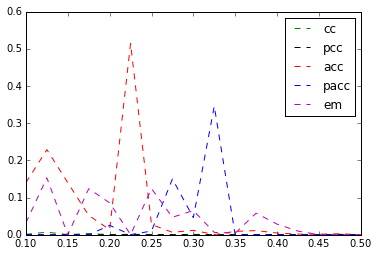

In [113]:
drift_list = []
cc_list, pcc_list, acc_list,pacc_list,em_list = [],[],[],[],[]

for i in range(100,501,25):
        X,y = generate_data(10000,30,[i/1000,1])
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)
#         print(pd.Series(y).value_counts())

        clf = svm.SVC(C=20, probability= True)
#         clf = KNC(n_neighbors=2)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        proba = clf.predict_proba(X_test)
        
        print(accuracy_score(y_test,predictions))
        
        fpr,tpr = get_positive_rate(X_train,y_train)
        efpr,etpr = get_exp_positive_rate(X_train,y_train)
        
        cc_real = CC(y_test)
        cc = CC(predictions)
        pcc = PCC(proba)
        acc = ACC(predictions,fpr,tpr)
        pacc = PACC(predictions,proba,efpr,etpr)
        em = EM(y_train,proba)


        print('CC:',kld(cc_real,cc))
        print('PCC:',kld(cc_real,pcc))
        print('ACC:',kld(cc_real,acc))
        print('PACC:',kld(cc_real,pacc))
        print('EM:',kld(cc_real,em))


        cc_list.append(kld(cc_real,cc)),pcc_list.append(kld(cc_real,pcc)),
        acc_list.append(kld(cc_real,acc)),pacc_list.append(kld(cc_real,pacc)),
        em_list.append(kld(cc_real,em))
        
        drift_list.append(i/1000)
        
print(len(cc_list))        
plt.figure()        
plt.plot(drift_list,cc_list, 'g--')
plt.plot(drift_list,pcc_list, 'k--')
plt.plot(drift_list,acc_list, 'r--')
plt.plot(drift_list,pacc_list, 'b--')
plt.plot(drift_list,em_list, 'm--')

plt.legend(['cc', 'pcc','acc', 'pacc','em'])

# Drift for 10

In [114]:
cc_cv, pcc_cv, acc_cv,pacc_cv,em_cv = [0]*17,[0]*17,[0]*17,[0]*17,[0]*17
rand_feature = []
for j in range(10):    
    random_feature_count = random.randint(2,100)
    rand_feature.append(random_feature_count)
    
    drift_list = []
    cc_list, pcc_list, acc_list,pacc_list,em_list = [],[],[],[],[]
    
    print(j)
    
    for i in range(100,501,25):
            X,y = generate_data(10000,random_feature_count,[i/1000,1])
            X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4)

            clf = svm.SVC(C=100, probability= True)
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_test)
            proba = clf.predict_proba(X_test)
            
            fpr,tpr = get_positive_rate(X_train,y_train,clf=clf)
            efpr,etpr = get_exp_positive_rate(X_train,y_train)
            
            cc_real = CC(y_test)
            cc = CC(predictions)
            pcc = PCC(proba)
            acc = ACC(predictions,fpr,tpr)
            pacc = PACC(predictions,proba,efpr,etpr)
            em = EM(y_train,proba)

            cc_list.append(kld(cc_real,cc)),pcc_list.append(kld(cc_real,pcc)),
            acc_list.append(kld(cc_real,acc)),pacc_list.append(kld(cc_real,pacc)),
            em_list.append(kld(cc_real,em))

            drift_list.append(i/1000)
            
    for i in range(len(cc_list)):
        cc_cv[i] += cc_list[i]
        pcc_cv[i] += pcc_list[i]
        acc_cv[i] += acc_list[i]
        pacc_cv[i] += pacc_list[i]
        em_cv[i] += em_list[i]
        
for i in range(len(cc_cv)): 
    cc_cv[i] = cc_cv[i]/10
    pcc_cv[i] = pcc_cv[i]/10
    acc_cv[i] = acc_cv[i]/10
    pacc_cv[i] = pacc_cv[i]/10
    em_cv[i] = em_cv[i]/10

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) i

0
1

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) i


2

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) i


3

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) i


4

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) i


5

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) i


6

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) i


7

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) i


8

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) i


9

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) i

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


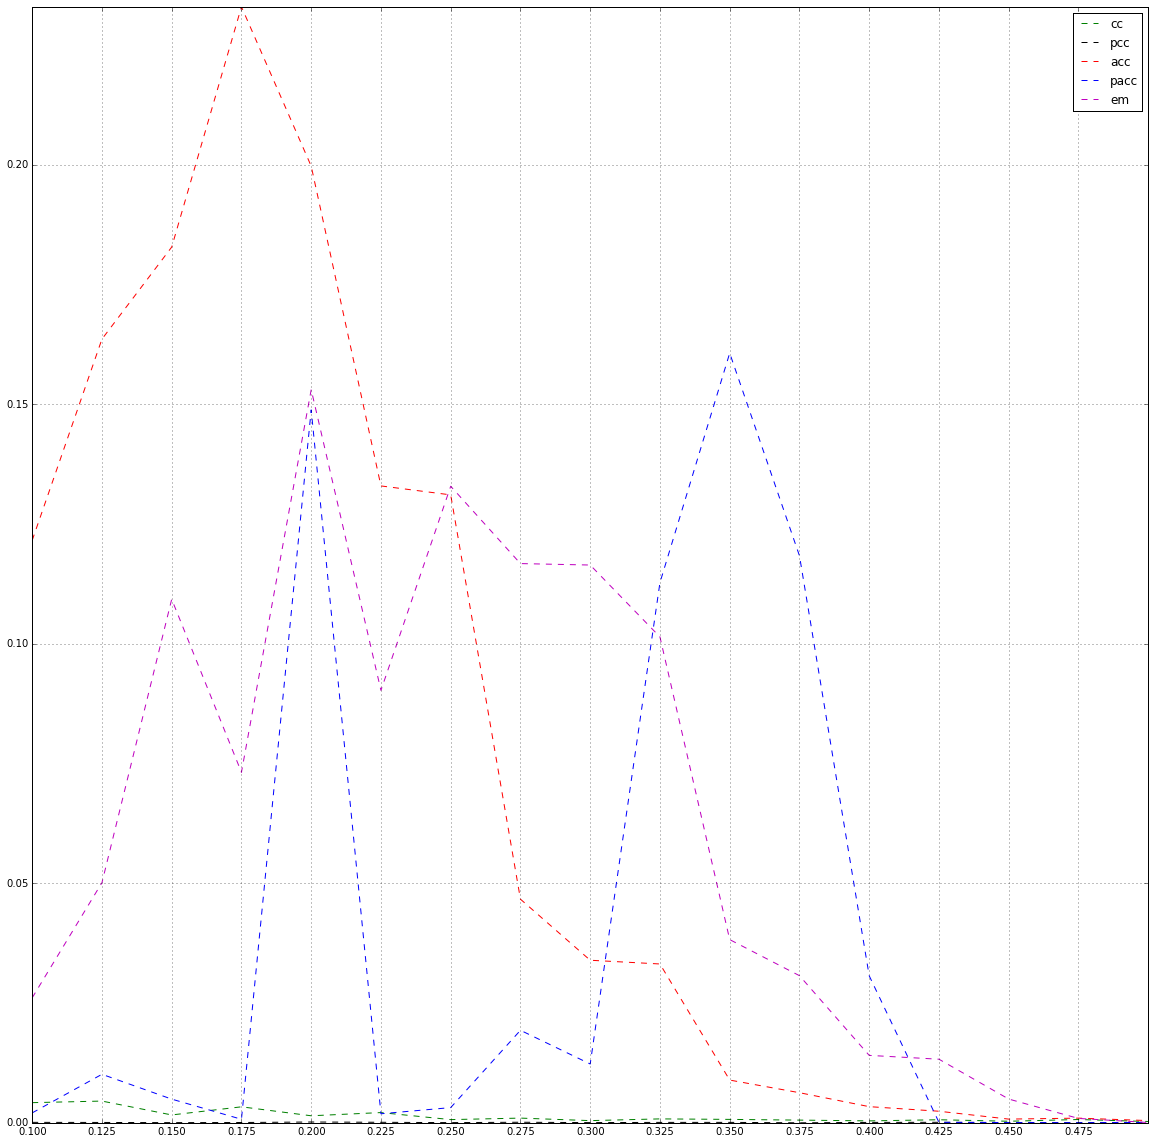

In [116]:
plt.figure(figsize=(20,20))
plt.xticks(np.arange(0.1, 0.5, 0.025))
plt.yticks(np.arange(0, 2, 0.05))
plt.grid()
plt.plot(drift_list,cc_cv,'g--')
plt.plot(drift_list,pcc_cv, 'k--')
plt.plot(drift_list,acc_cv, 'r--')
plt.plot(drift_list,pacc_cv, 'b--')
plt.plot(drift_list,em_cv, 'm--')

plt.legend(['cc', 'pcc','acc', 'pacc','em'])
plt.savefig('quant')

In [117]:
print(rand_feature)
print('cc',cc_cv[:],'\n', 'pcc',pcc_cv[:],'\n','acc', acc_cv[:],'\n','pacc',pacc_cv[:],'\n','em',em_cv[:])

[10, 78, 65, 39, 5, 59, 98, 42, 91, 92]
cc [0.0042188960210477276, 0.0045478714798396838, 0.0016536832517639536, 0.0033492108975661538, 0.0014797226363199843, 0.0021489584870397491, 0.00068031268934700111, 0.00099373161496556272, 0.00046788319886441408, 0.00082997538370485136, 0.00072528486784105507, 0.0005752849098669239, 0.00041373249317715188, 0.0006513845984808871, 0.00033762465729659207, 0.00070068636843962349, 0.00028669038887035468] 
 pcc [0.00010641684414768463, 8.5531309974070546e-05, 4.9022935104263505e-05, 7.4421253809225276e-05, 0.00017730586101997876, 0.00012038424881913937, 4.9733554967104565e-05, 0.00013015918448352291, 5.2726374191394209e-05, 9.7760939894461386e-05, 0.00010210395583404312, 1.4000812390289864e-05, 9.5237138649260689e-05, 0.00011681258430671989, 6.9237394048624027e-05, 3.6042145141140207e-05, 9.7010088762590696e-05] 
 acc [0.1215787711382366, 0.16357434281324001, 0.18277663941559838, 0.23292429629304062, 0.19966742843743285, 0.13292924912842405, 0.1310614

# SemEval

In [753]:
def tweet_preprocessing(tweet):
    tweet = tweet.lower()        
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)        
    tweet = re.sub('@','',tweet)
    tweet = re.sub('^[\s]', '', tweet)
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)       
    tweet = tweet.strip('\'"')
    tweet = "".join(word for word in tweet if word not in string.punctuation)    
    tweet = tweet.split()    
    numbers = re.compile(r'^[\d]+.*')
    tweet = [j for j in tweet if not numbers.search(j)]
    tweet = ' '.join([x for x in tweet]) 

    return tweet    

In [754]:
train = pd.read_csv('SemEval/pretrain_2_gold.csv',sep='\t', header=None)
test_gold = pd.read_csv('SemEval/test_gold_2.csv',sep='\t', header=None)
tweets = []
y = []
topic =[]


for i,tweet in enumerate(train[3]):
    if tweet != 'Not Available':
        tweet = tweet_preprocessing(tweet)           
        
        if train[2].values[i] == 'negative':
            sem = 0
        else:
            sem = 1
            
        y.append(int(sem)),tweets.append(tweet),topic.append(train[1].values[i])
       
size = len(y)

for i,tweet in enumerate(test_gold[3]):
    if tweet != 'Not Available':
        tweet = tweet_preprocessing(tweet)           
        
        if test_gold[2].values[i] == 'negative':
            sem = 0
        else:
            sem = 1
            
        y.append(int(sem)),tweets.append(tweet),topic.append(test_gold[1].values[i])

y_train = pd.Series(y[:size])
y_test = pd.Series(y[size:])
topic_train, topic_test = topic[:size], topic[size:]
print(len(y),len(y_train),len(y_test),topic[size:size+1])

15221 6274 8947 ['amy schumer']


In [755]:
vectorizer = TfidfVectorizer(analyzer = "word",
                           tokenizer = None,
                           preprocessor = None,
                           stop_words = 'english'
                            )
tweets = vectorizer.fit_transform(tweets)
X_train, X_test = tweets[:size],tweets[size:]

In [756]:
clf = svm.SVC(C=100, kernel='linear', probability= True)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
proba = clf.predict_proba(X_test)

print('ROC:',roc_auc_score(y_test,predictions))
            
fpr,tpr = get_positive_rate(X_train,y_train,clf=clf)
efpr,etpr = get_exp_positive_rate(X_train,y_train,clf=clf)

ROC: 0.606881536609


In [757]:
cc_real = CC(y_test)
cc = CC(predictions)
pcc = PCC(proba)
acc = ACC(predictions,fpr,tpr)
pacc = PACC(predictions,proba,efpr,etpr)
em = EM(y_train,proba)

In [758]:
obtainSVMperfTwoPoint(y_train.tolist(),X_train.toarray(), "train")
obtainSVMperfTwoPoint(y_test.tolist(),X_test.toarray(), "test")

In [759]:
# svm_perf = SVM_perf()
svm_perf_pred, svm_perf = SVM_perf(150)

Reading training examples...done
Training set properties: 25296 features, 6274 examples (5062 pos / 1212 neg)
Iter 1: :*(NumConst=1, SV=1, CEps=100.0000, QPEps=0.0000)
Iter 2: :*(NumConst=2, SV=2, CEps=50.6116, QPEps=0.0005)
Iter 3: :*(NumConst=3, SV=2, CEps=39.1201, QPEps=0.0003)
Iter 4: :*(NumConst=4, SV=3, CEps=35.8044, QPEps=0.0001)
Iter 5: :*(NumConst=5, SV=4, CEps=20.1033, QPEps=0.0001)
Iter 6: :*(NumConst=6, SV=4, CEps=23.2126, QPEps=0.0035)
Iter 7: :*(NumConst=7, SV=4, CEps=12.9766, QPEps=0.0244)
Iter 8: :*(NumConst=8, SV=5, CEps=7.8574, QPEps=0.0071)
Iter 9: :*(NumConst=9, SV=5, CEps=7.8258, QPEps=0.0207)
Iter 10: :*(NumConst=10, SV=6, CEps=5.8671, QPEps=0.0035)
Iter 11: :*(NumConst=11, SV=6, CEps=7.7749, QPEps=0.0078)
Iter 12: :*(NumConst=12, SV=6, CEps=7.8937, QPEps=0.0011)
Iter 13: :*(NumConst=13, SV=8, CEps=5.2434, QPEps=2.2241)
Iter 14: :*(NumConst=14, SV=8, CEps=3.6402, QPEps=0.0066)
Iter 15: :*(NumConst=15, SV=10, CEps=2.5273, QPEps=0.7519)
Iter 16: :*(NumConst=16, SV=1

In [760]:
# print(len(svm_perf))
# print(len(svm_perf),len(y_test))
print('ROC:',roc_auc_score(y_test,svm_perf_pred))

ROC: 0.606940689606


In [761]:
print('CC:',kld(cc_real,cc))
print('PCC:',kld(cc_real,pcc))
print('ACC:',kld(cc_real,acc))
print('PACC:',kld(cc_real,pacc))
print('EM:',kld(cc_real,em))
print('SVMperf:',kld(cc_real,svm_perf))

CC: 0.0240682203499
PCC: 0.00121965370834
ACC: 0.472977186861
PACC: 0.00238016294687
EM: 0.00121965370834
SVMperf: 0.0684795958373


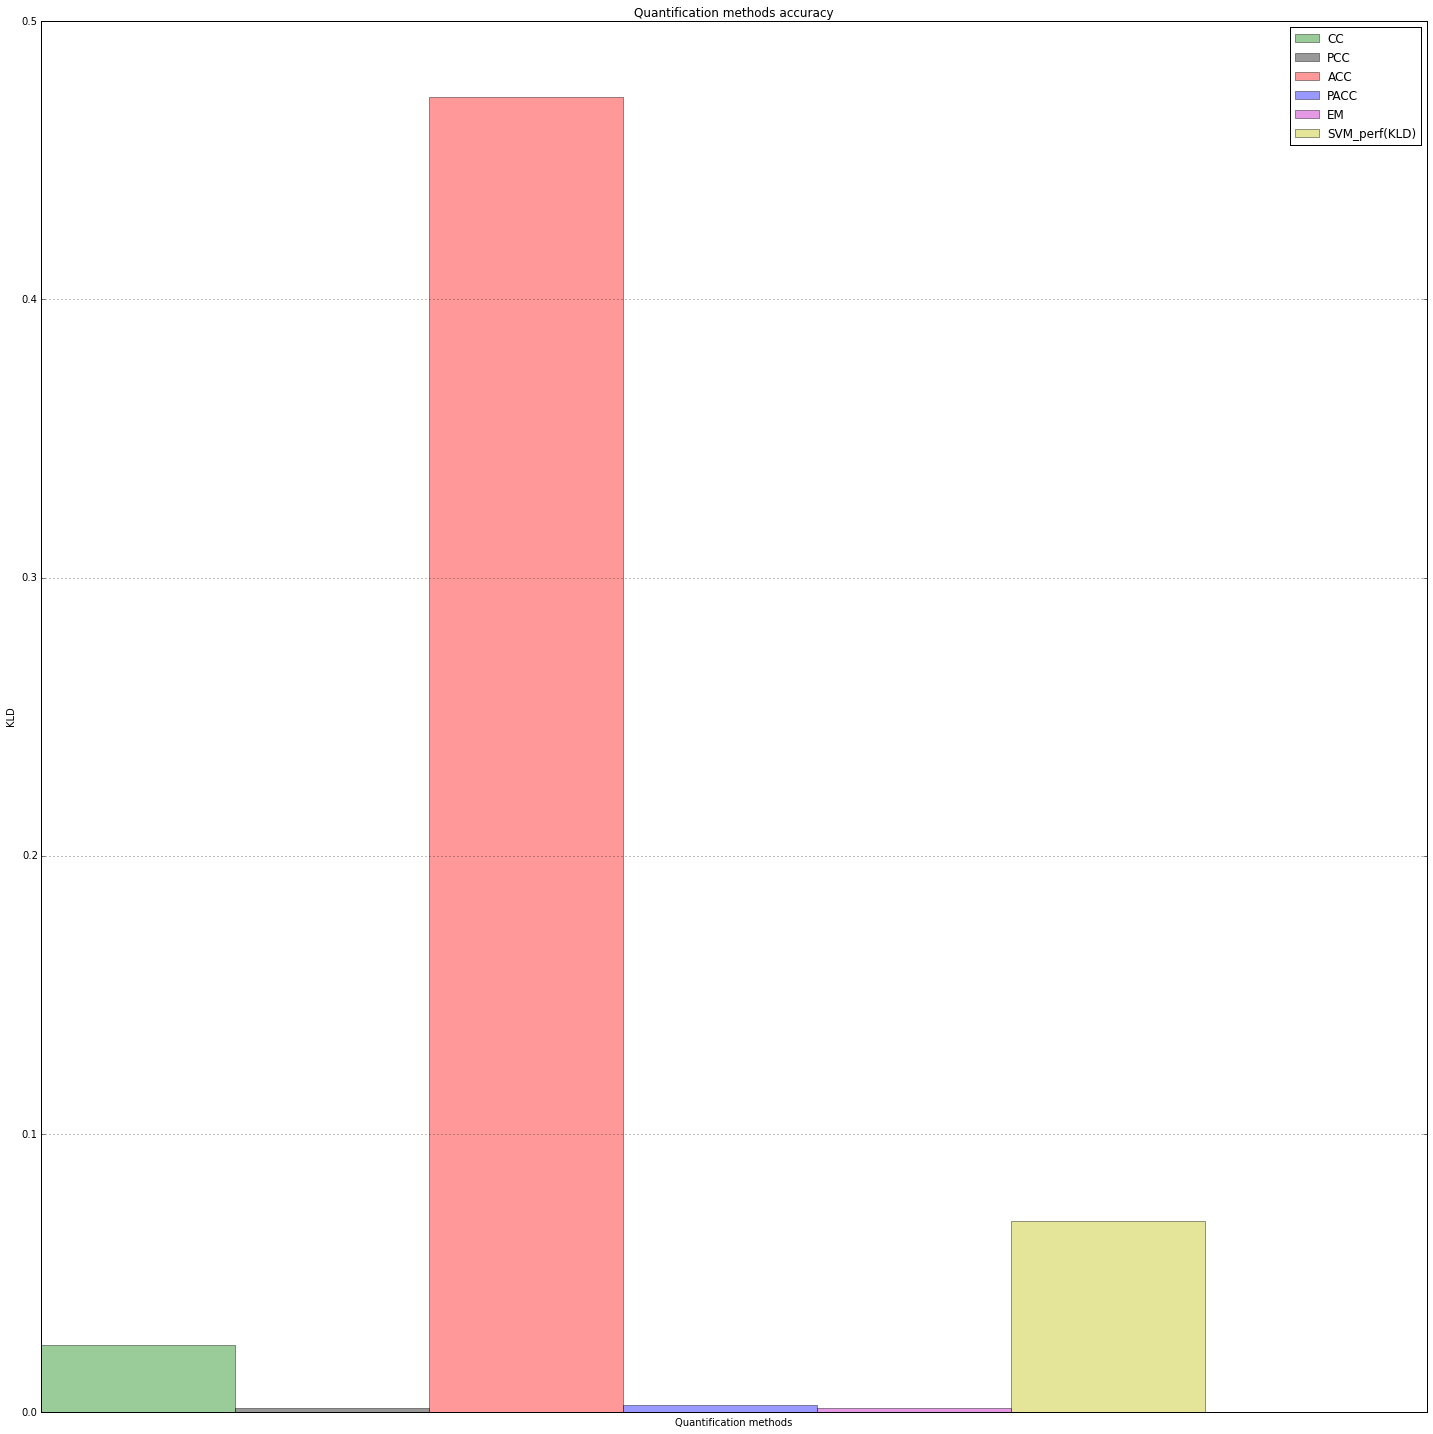

In [532]:
cc_p = kld(cc_real,cc)
pcc_p = kld(cc_real,pcc)
acc_p = kld(cc_real,acc)
pacc_p = kld(cc_real,pacc)
em_p = kld(cc_real,em)
svm_p = kld(cc_real,svm_perf)

plt.figure(figsize=(20,20))
# fig, ax = plt.subplots()
# index = np.arange(1)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.1'}
plt.grid()
plt.bar(1, cc_p, bar_width,
                 alpha=opacity,
                 color='g',                 
                 error_kw=error_config,
                 label='CC')

plt.bar(1+bar_width, pcc_p, bar_width,
                 alpha=opacity,
                 color='k',                
                 error_kw=error_config,
                 label='PCC')

plt.bar(1+bar_width*2, acc_p, bar_width,
                 alpha=opacity,
                 color='r',                
                 error_kw=error_config,
                 label='ACC')

plt.bar(1+bar_width*3, pacc_p, bar_width,
                 alpha=opacity,
                 color='b',                
                 error_kw=error_config,
                 label='PACC')

plt.bar(1+bar_width*4, em_p, bar_width,
                 alpha=opacity,
                 color='m',                
                 error_kw=error_config,
                 label='EM')

plt.bar(1+bar_width*5, svm_p, bar_width,
                 alpha=opacity,
                 color='y',                
                 error_kw=error_config,
                 label='SVM_perf(KLD)')

plt.xlabel('Quantification methods')
plt.ylabel('KLD')
plt.title('Quantification methods accuracy')
plt.xticks(np.arange(1))


plt.legend()

plt.tight_layout()
plt.savefig('sem_eval_all_2')
plt.show()


In [762]:
title_pred = []
title_real = []
title_proba = []
title_svm = []

title = topic_test[0]

uniq_title = []
quant_list = []
real_quant_list = []
proba_quant_list = []
svm_list = []

for i in range(len(topic_test)):
    if topic_test[i] == title:
        title_pred.append(predictions[i])
        title_proba.append(proba[i])
        title_real.append(y_test[i])
        title_svm.append(svm_perf_pred[i])
    else:
        uniq_title.append(title)
        title = topic_test[i]
        
        quant_list.append(title_pred)
        real_quant_list.append(title_real)
        proba_quant_list.append(title_proba)
        svm_list.append(title_svm)
        
        title_pred = []
        title_proba = []
        title_real = []
        
uniq_title.append(title)
quant_list.append(title_pred)
real_quant_list.append(title_real)      
proba_quant_list.append(title_proba)
svm_list.append(title_svm)

In [488]:
for i,lst in enumerate(quant_list):
    print(uniq_title[i],
          kld(CC(real_quant_list[i]),CC(lst)),
          kld(CC(real_quant_list[i]),PCC(np.array(proba_quant_list[i]))),
          kld(CC(real_quant_list[i]),ACC(lst,fpr,tpr)),
          kld(CC(real_quant_list[i]),PACC(lst,proba_quant_list[i],efpr,etpr)),
          kld(CC(real_quant_list[i]),EM(y_train,np.array((proba_quant_list[i])))),
          kld(CC(real_quant_list[i]),CC(svm_list[i])),
         )

amy schumer 0.0245137376671 0.0540240031212 0.276659089269 0.0837971695453 0.0540240031212 0.0280357151128
ant-man 0.121225742321 0.173690752691 0.00955605582566 0.178030552468 0.173690752691 0.0309049794721
bad blood 0.00436388066459 8.64894306721e-07 0.562912099081 0.000232110085425 8.64894306721e-07 0.11355149681
bee gees 0.00595189009074 0.102134003806 0.0 0.0861779000576 0.102134003806 0.062847823672
big brother 0.0341050084764 0.00419957815869 0.503382516804 0.00683771676805 0.00419957815869 0.0788418314123
boko haram 0.21867063118 0.269097470339 0.000257671006688 0.302876204263 0.269097470339 0.0508249247262
briana 0.265948336712 0.104865890132 1.31692156147 0.103700756004 0.104865890132 0.415186753588
brock lesnar 0.0294890129257 0.0972006784632 0.0 0.0813099665889 0.0972006784632 0.062847823672
caitlyn jenner 0.0182667766299 0.000422039275847 0.720057109569 0.00720872458092 0.000422039275847 0.175890108296
calibraska 0.0115729756207 0.0946807777019 0.0 0.0788465316505 0.094680

In [763]:
file = open('table.csv','w')
file.write('Title;CC;PCC;ACC;PACC;EM;SVM_perf\n')
for i,lst in enumerate(quant_list):
    file.write(str(uniq_title[i])+';'+
          str(kld(CC(real_quant_list[i]),CC(lst)))+';'+
          str(kld(CC(real_quant_list[i]),PCC(np.array(proba_quant_list[i]))))+';'+
          str(kld(CC(real_quant_list[i]),ACC(lst,fpr,tpr)))+';'+
          str(kld(CC(real_quant_list[i]),PACC(lst,proba_quant_list[i],efpr,etpr)))+';'+
          str(kld(CC(real_quant_list[i]),EM(y_train,np.array((proba_quant_list[i])))))+';'+
          str(kld(CC(real_quant_list[i]),CC(svm_list[i])))+'\n'
         )
file.close()

In [764]:
data_frame = pd.read_csv('table.csv',sep=';')
for item in (data_frame.values).T[1:]:
    print(np.average((item).tolist()))

0.0717923966492
0.0670396337086
0.340626388454
0.0725826445509
0.0670396337086
0.0964754186517


In [505]:
data_frame

,Title,CC,PCC,ACC,PACC,EM,SVM_perf
0,amy schumer,0.024514,5.402400e-02,0.276659,8.379717e-02,5.402400e-02,0.028036
1,ant-man,0.121226,1.736908e-01,0.009556,1.780306e-01,1.736908e-01,0.030905
2,bad blood,0.004364,8.648943e-07,0.562912,2.321101e-04,8.648943e-07,0.113551
3,bee gees,0.005952,1.021340e-01,0.000000,8.617790e-02,1.021340e-01,0.062848
4,big brother,0.034105,4.199578e-03,0.503383,6.837717e-03,4.199578e-03,0.078842
5,boko haram,0.218671,2.690975e-01,0.000258,3.028762e-01,2.690975e-01,0.050825
6,briana,0.265948,1.048659e-01,1.316922,1.037008e-01,1.048659e-01,0.415187
7,brock lesnar,0.029489,9.720068e-02,0.000000,8.130997e-02,9.720068e-02,0.062848
8,caitlyn jenner,0.018267,4.220393e-04,0.720057,7.208725e-03,4.220393e-04,0.175890
9,calibraska,0.011573,9.468078e-02,0.000000,7.884653e-02,9.468078e-02,0.062848


In [765]:
title_p = []
cc_p = []
pcc_p = []
acc_p = []
pacc_p = []
em_p = []
svm_p = []
for i,lst in enumerate(quant_list):
    title_p.append(uniq_title[i])
    cc_p.append(kld(CC(real_quant_list[i]),CC(lst)))
    pcc_p.append(kld(CC(real_quant_list[i]),PCC(np.array(proba_quant_list[i]))))
    acc_p.append(kld(CC(real_quant_list[i]),ACC(lst,fpr,tpr)))
    pacc_p.append(kld(CC(real_quant_list[i]),PACC(lst,proba_quant_list[i],efpr,etpr)))
    em_p.append(kld(CC(real_quant_list[i]),exp_max(y_train,np.array((proba_quant_list[i])))))
    svm_p.append(kld(CC(real_quant_list[i]),CC(svm_list[i])))

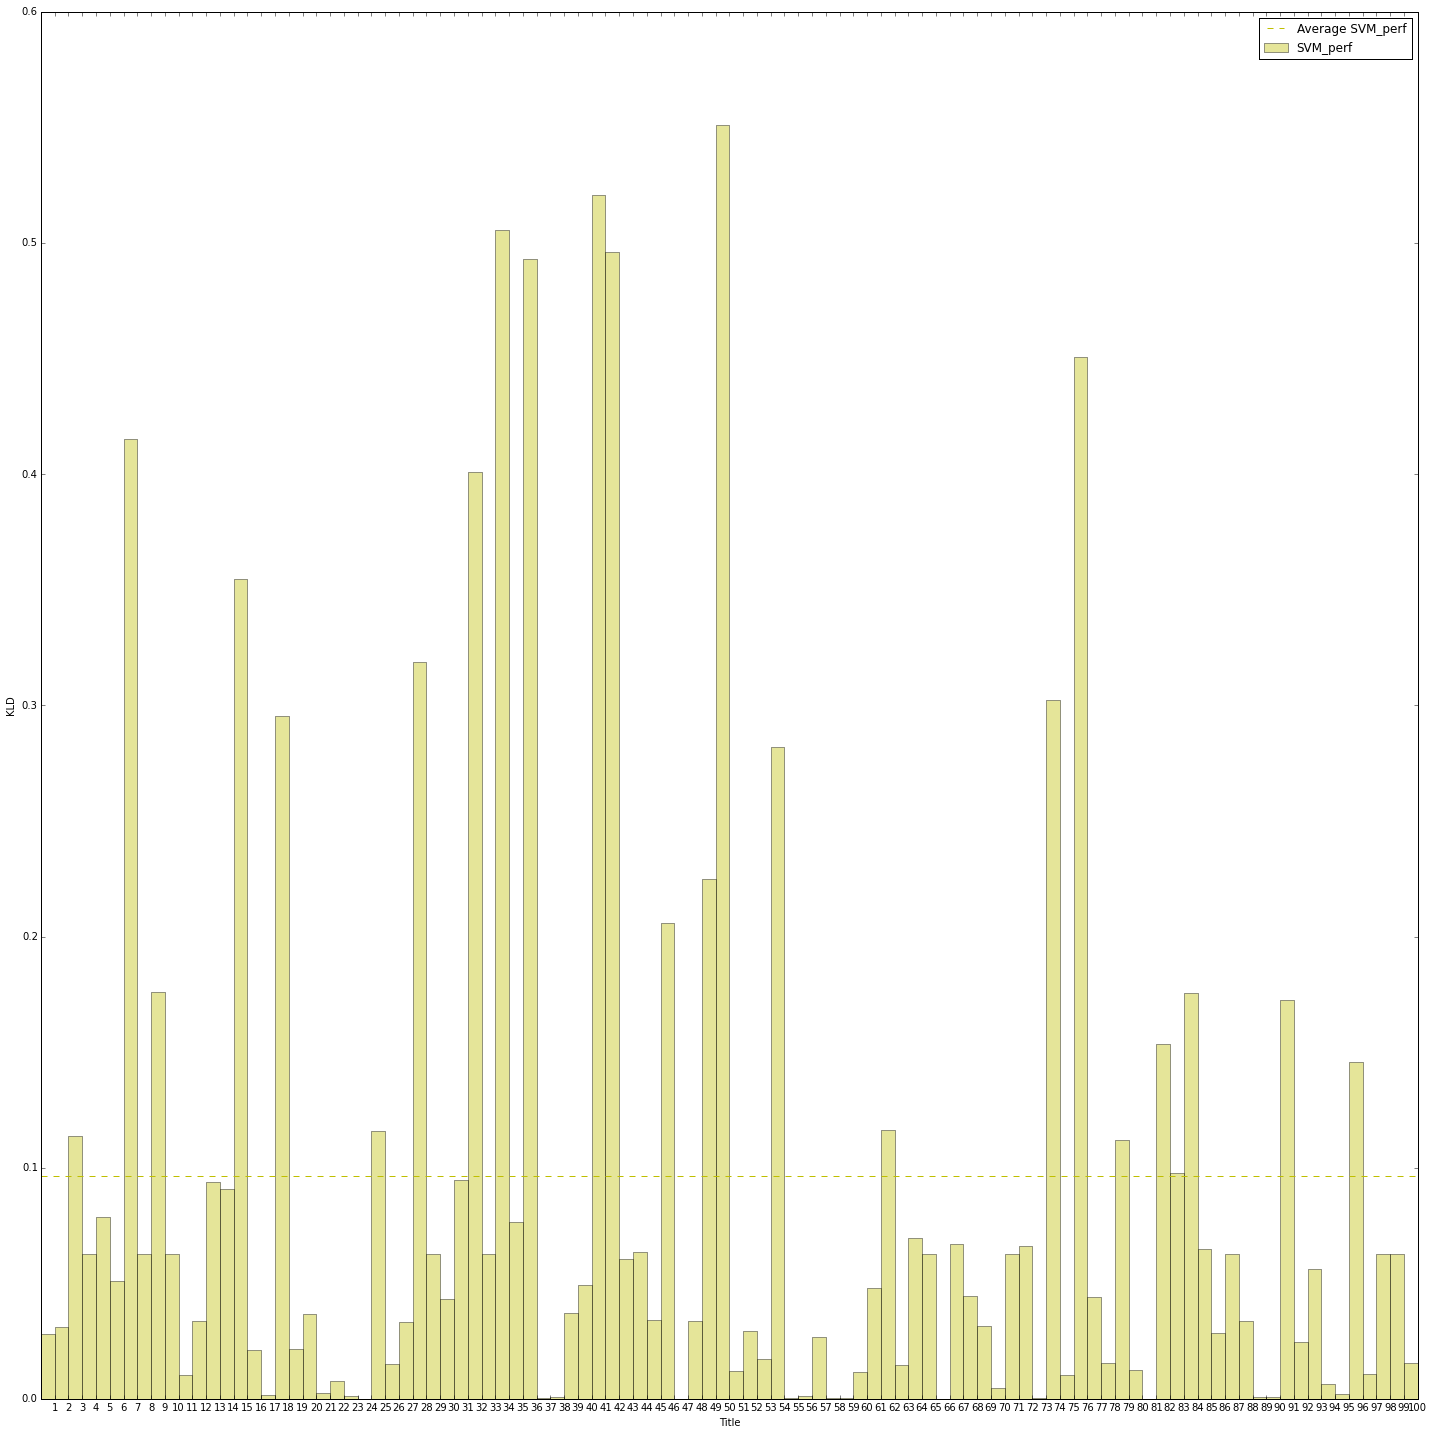

In [791]:
plt.figure(figsize=(20,20))
# fig, ax = plt.subplots()
index = np.arange(len(title_p))
bar_width = 1

opacity = 0.4
error_config = {'ecolor': '0.1'}
# plt.grid()
# plt.bar(index, cc_p, bar_width,
#                  alpha=opacity,
#                  color='g',                 
#                  error_kw=error_config,
#                  label='CC')

# plt.bar(index, pcc_p, bar_width,
#                  alpha=opacity,
#                  color='k',                
#                  error_kw=error_config,
#                  label='PCC')

# plt.bar(index, acc_p, bar_width,
#                  alpha=opacity,
#                  color='r',                
#                  error_kw=error_config,
#                  label='ACC')

# plt.bar(index, pacc_p, bar_width,
#                  alpha=opacity,
#                  color='b',                
#                  error_kw=error_config,
#                  label='PACC')

plt.bar(index, svm_p, bar_width,
                 alpha=opacity,
                 color='y',                
                 error_kw=error_config,
                 label='SVM_perf')

plt.xlabel('Title')
plt.ylabel('KLD')
# plt.title('Quantification methods accuracy')
plt.xticks(index + bar_width)

x = np.arange(0,101)
y = [0.09648 for i in x]
plt.plot(x, y,'y--',label='Average SVM_perf')

plt.legend()

plt.tight_layout()
plt.savefig('sem_eval_all_svm')
plt.show()

In [779]:
[['%.5f' % np.average((item).tolist())] for item in (data_frame.values).T[1:]]

[['0.07179'], ['0.06704'], ['0.34063'], ['0.07258'], ['0.06704'], ['0.09648']]

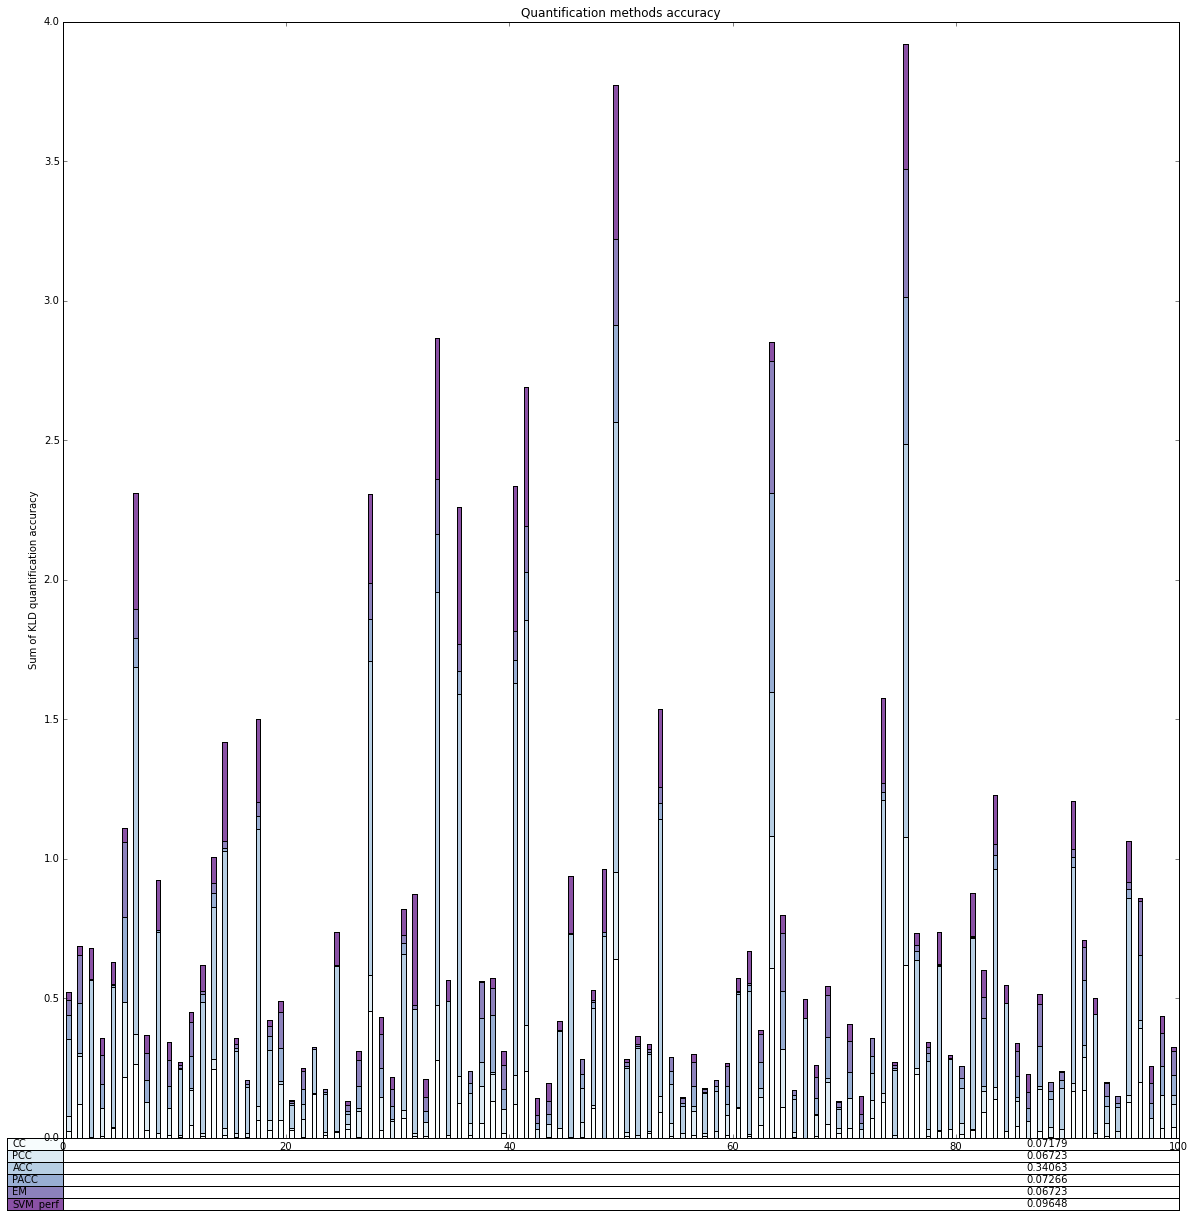

In [504]:
"""
Demo of table function to display a table within a plot.
"""
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
data = [cc_p,
        pcc_p,
        acc_p,
        pacc_p,
        em_p,
        svm_p]

columns = title_p
rows = ['CC','PCC','ACC','PACC','EM','SVM_perf']

values = np.arange(0, 2500, 500)
value_increment = 1000

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, .7, len(rows)))
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.array([0.0] * len(columns))


cell_text = [ ['%.5f' % np.average((item).tolist())] for item in (data_frame.values).T[1:]]

for row in range(n_rows):
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]

plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      loc='bottom'
         )

# Adjust layout to make room for the table:
# plt.subplots_adjust(right=0.9, bottom=0.1)

plt.ylabel("Sum of KLD quantification accuracy")
plt.title('Quantification methods accuracy')

plt.savefig('sem_eval_all_topics')

In [533]:
print(len(y_train),len(y_test))
print(cc_real)

6274 8947
[0.78394992734994973, 0.2160500726500503]


## for 5th

In [545]:
train = pd.read_csv('SemEval/pretrain_5_gold.csv',sep='\t', header=None)
test_gold = pd.read_csv('SemEval/test_gold_2.csv',sep='\t', header=None)
test_5_gold = pd.read_csv('SemEval/test_5_gold.csv',sep='\t', header=None)
tweets = []
y = []
topic =[]

for i,tweet in enumerate(train[3]):
    if tweet != 'Not Available':
        tweet = tweet_preprocessing(tweet)                       
        y.append(int(train[2].values[i])),tweets.append(tweet),topic.append(train[1].values[i])
       
size = len(y)

for i,tweet in enumerate(test_gold[3]):
    if tweet != 'Not Available':
        tweet = tweet_preprocessing(tweet)           
        y.append(int(test_5_gold[2].values[i])),tweets.append(tweet),topic.append(test_gold[1].values[i])

y_train = pd.Series(y[:size])
y_test = pd.Series(y[size:])
topic_train, topic_test = topic[:size], topic[size:]


# print(len(y),len(y_train),len(y_test),len(topic_test),topic[size:size+1])

In [741]:
from sklearn.multiclass import OneVsRestClassifier as mc

clf = mc(svm.SVC(C=1050, kernel='linear', probability=True)) # for multi classes
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
proba = clf.predict_proba(X_test)

# print('ROC:',roc_auc_score(y_test,predictions))

In [742]:
print(kld(CC(y_test),CC(predictions)))

0.0491097428393


In [749]:
cc_real = CC(y_test)
cc = CC(predictions)
pcc = PCC(proba)
em = EM(y_train,proba)

In [750]:
print(em)

[  9.07605850e-29   2.46936760e-15   1.77538140e-06   9.99631360e-01
   3.66864405e-04]


In [751]:
print('CC:',kld(cc_real,cc))
print('PCC:',kld(cc_real,pcc))
print('EM:',kld(cc_real,em))


CC: 0.0491097428393
PCC: 0.677260200912
EM: 43.8506770647


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


ValueError: need more than 1 value to unpack

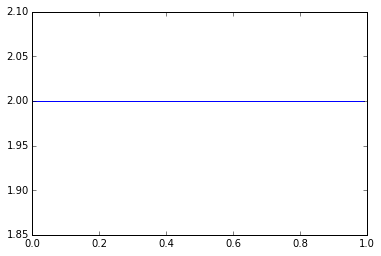

In [775]:
x = np.arange(0, 1.0, 0.01)
y1 = [2 for i in x]
print(y1)
y2 = np.sin(4*np.pi*x)
lines = plt.plot(x, y1)
l1, l2 = lines
plt.setp(lines, linestyle='--')       # set both to dashed
plt.setp(l1, linewidth=2, color='r')  # line1 is thick and red
plt.setp(l2, linewidth=1, color='g')  # line2 is thicker and green


print('Line setters')
plt.setp(l1)
print('Line getters')
plt.getp(l1)

print('Rectangle setters')
plt.setp(plt.gca().patch)
print('Rectangle getters')
plt.getp(plt.gca().patch)

t = plt.title('Hi mom')
print('Text setters')
plt.setp(t)
print('Text getters')
plt.getp(t)

plt.show()